---
title: Gradient Considerations
date: 2023-04-01
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: NerFs, Images
---

In [1]:

import autoroot
import typing as tp
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrandom
import numpy as np
import numba as nb
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from omegaconf import OmegaConf
import hydra
import metpy
from sklearn.pipeline import Pipeline
from jejeqx._src.transforms.dataframe.spatial import Spherical2Cartesian
from jejeqx._src.transforms.dataframe.temporal import TimeDelta
from jejeqx._src.transforms.dataframe.scaling import MinMaxDF


sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", False)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Recap Formulation

We are interested in learning non-linear functions $\boldsymbol{f}$.

$$
\begin{aligned}
\boldsymbol{f}(\mathbf{x}) &=
\mathbf{w}^\top\boldsymbol{\phi}(\mathbf{x})+\mathbf{b}
\end{aligned}
$$

where the $\boldsymbol{\phi}(\cdot)$ is a basis function. Neural Fields typically try to learn this basis funciton via a series of composite functions of the form

$$
\boldsymbol{\phi}(\mathbf{x}) =
\boldsymbol{\phi}_L\circ\boldsymbol{\phi}_{L-1}
\circ\cdots\circ
\boldsymbol{\phi}_2\circ\boldsymbol{\phi}_{1}(\mathbf{x})
$$

## Problems

Here, we will demonstrate a problem that a naive network has.

## Data

In [2]:
# !wget wget -nc https://s3.us-east-1.wasabisys.com/melody/osse_data/ref/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc

In [3]:
from pathlib import Path

In [4]:
Path("/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/natl60/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc").is_file()

True

In [5]:
from dataclasses import dataclass, field
from typing import List, Dict

@dataclass
class Subset:
    _target_: str = "builtins.slice"
    _args_: List = field(default_factory=lambda :["2013-01-01", "2013-01-01"])


@dataclass
class SSHDM:
    _target_: str = "jejeqx._src.datamodules.coords.AlongTrackDM"
    batch_size: int = 1000
    shuffle: bool = False
    train_size: float = 0.80
    subset_size: float = 0.40
    spatial_coords: List = field(default_factory=lambda : ["lat", "lon"])
    temporal_coords: List = field(default_factory=lambda: ["time"])
    variables: List = field(default_factory=lambda : ["ssh"])
    # coarsen: Dict = field(default_factory=lambda : {"lon": 2, "lat": 2})
    resample: str = "1D"
    decode_times: bool = False
    paths: str = "/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/natl60/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc"
    # paths: str = "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/test/dc_ref/NATL60-CJM165_GULFSTREAM*"
    
    

# spatial transform
spatial_transforms = Pipeline([
    # ("cartesian3d", Spherical2Cartesian(radius=1.0, units="degrees")),
    ("spatialminmax", MinMaxDF(["lat", "lon"], -1, 1)),
])

temporal_transforms = Pipeline([
    ("timedelta", TimeDelta("2012-10-01", 1, "s")),
    ("timeminmax", MinMaxDF(["time"], -1, 1)),
])

In [6]:
select = {"time": slice("2013-01-01", "2013-01-01")}

config_dm = OmegaConf.structured(SSHDM())

dm = hydra.utils.instantiate(
    config_dm,
    select=select,
    spatial_transform=spatial_transforms,
    temporal_transform=temporal_transforms
)

dm.setup()



init = dm.ds_train[:32]
x_init, t_init, y_init = init["spatial"], init["temporal"], init["data"]
x_init.min(), x_init.max(), x_init.shape, t_init.min(), t_init.max(), t_init.shape

Index(['lat', 'lon'], dtype='object') Index(['time'], dtype='object') Index(['ssh'], dtype='object')


/gpfsdswork/projects/rech/cli/uvo53rl/projects/jejeqx/jejeqx/_src/transforms/dataframe/temporal.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["time"] = time


(-0.9800000000000004, 1.0, (32, 2), -1.0, -1.0, (32, 1))

In [7]:
len(dm.ds_train)

12928

In [8]:
xrda = dm.load_xrds()

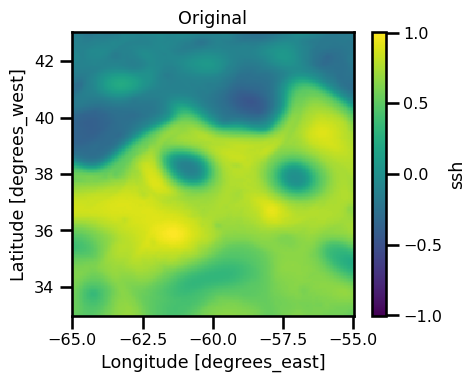

In [9]:
fig, ax = plt.subplots(ncols=1, figsize=(5,4))

xrda.ssh.isel(time=0).plot.pcolormesh(ax=ax, cmap="viridis")
ax.set(title="Original")

plt.tight_layout()
plt.show()

In [10]:
# lr = 5e-3
# num_epochs = 5_000
# num_steps_per_epoch = len(dm.ds_train)

# @dataclass
# class FoxDataModule:
#     _target_: str = "jejeqx._src.datamodules.image.ImageFox"
#     batch_size: int = 10_000
#     train_size: float = 0.5
#     shuffle: bool = False
#     split_method: str = "even"
#     resize: int = 4
    
# @dataclass
# class Training:
#     num_epochs: int = 2_000

# @dataclass
# class Model:
#     _target_: str = "jejeqx._src.nets.nerfs.siren.SirenNet"
#     in_size: int = 2
#     out_size: int = 3
#     width_size: int = 128
#     depth: int = 5

# @dataclass
# class Optimizer:
#     _target_: str = "optax.adam"
#     learning_rate: float = lr
    
# @dataclass
# class Scheduler:
#     _target_: str = "optax.warmup_cosine_decay_schedule"
#     init_value: float = 0.0
#     peak_value: float = lr
#     warmup_steps: int = 100
#     decay_steps: int = int(num_epochs * num_steps_per_epoch)
#     end_value: float = 0.01 * lr
    
# @dataclass
# class Config:
#     datamodule: FoxDataModule = FoxDataModule()
#     model: Model = Model()
#     optimizer: Optimizer = Optimizer()
#     scheduler: Scheduler = Scheduler()
#     num_epochs: int = 2_000

In [11]:
# import optax

# config = Config()
# config = OmegaConf.structured(Config())

# # initialize datamodule
# dm = hydra.utils.instantiate(config.datamodule)

# dm.setup()


# # initialize optimizer
# optimizer = hydra.utils.instantiate(config.optimizer)

# # initialize scheduler
# num_steps_per_epoch = len(dm.ds_train)
# decay_steps = int(num_steps_per_epoch * config.num_epochs)
# schedule_fn = hydra.utils.instantiate(config.scheduler, decay_steps=decay_steps)

# # initialize optimizer + scheduler
# optimizer = optax.chain(optimizer, optax.scale_by_schedule(schedule_fn))



In [12]:
# ibatch = next(iter(dm.train_dataloader()))

# print(ibatch[0].shape, ibatch[1].shape, type(ibatch[0]))

## Model

The input data is a coordinate vector, $\mathbf{x}_\phi$, of the image coordinates.

$$
\mathbf{x}_\phi \in \mathbb{R}^{D_\phi}
$$

where $D_\phi = [\text{x}, \text{y}]$. So we are interested in learning a function, $\boldsymbol{f}$, such that we can input a coordinate vector and output a scaler/vector value of the pixel value.

$$
\mathbf{u} = \boldsymbol{f}(\mathbf{x}_\phi; \boldsymbol{\theta})
$$

### MLP Layer

$$
\mathbf{f}_\ell(\mathbf{x}) = \sigma\left(\mathbf{w}^{(\ell)}\mathbf{x} + \mathbf{b}^{(\ell)} \right)
$$

where $\sigma$ is the *swish* activation function.

$$
\sigma(\mathbf{x}) = \mathbf{x} \odot \text{Sigmoid}(\mathbf{x})
$$

In [13]:
from typing import Dict
from dataclasses import field


@dataclass
class Key:
    _target_: str = "jax.random.PRNGKey"
    seed: int = 123


@dataclass
class Activation:
    # _target_: str = "jejeqx._src.nets.activations.Tanh"
    _target_: str = "jejeqx._src.nets.activations.ReLU"
    # _target_: str = "jejeqx._src.nets.activations.Swish"

@dataclass
class Identity:
    _target_: str = "equinox.nn.Identity"
    
@dataclass
class MLPModel:
    _target_: str = "equinox.nn.MLP"
    in_size: int = 2
    out_size: int = 1
    width_size: int = 128
    depth: int = 5
    activation: Activation = Activation()
    final_activation: Identity = Identity()
    key: Key = Key()




In [14]:
# initialize model
model_config = OmegaConf.structured(MLPModel())

model = hydra.utils.instantiate(model_config)

# check output of models
out = jax.vmap(model)(x_init)

assert out.shape == y_init.shape
# eqx.tree_pprint(model)

## Optimizer (+ Learning Rate)

For this, we will use a simple adam optimizer with a `learning_rate` of 1e-4. From many studies, it appears that a lower learning rate works well with this methods because there is a lot of data. In addition, a bigger `batch_size` is also desireable. We will set the `num_epochs` to `1_000` which should be good enough for a single image. Obviously more epochs and a better learning rate scheduler would result in better results but this will be sufficient for this demo.

### Scheduler

<p align="center">
<img src="http://www.bdhammel.com/assets/learning-rate/resnet_loss.png" alt="drawing" width="300"/>
<figcaption align = "center">
  <b>Fig.1 - An example for learning rate reduction when the validation loss stagnates. Source: 
    <a href="http://www.bdhammel.com/assets/learning-rate/resnet_loss.png">Blog</a>
  </b>
  </figcaption>
</p>

We will use a simple learning rate scheduler - `reduce_lr_on_plateau`. This will automatically reduce the learning rate as the validation loss stagnates. It will ensure that we really squeeze out as much performance as possible from our models during the training procedure.We start with a (relatively) high `learning_rate` of `1e-4` so we will set the `patience` to 5 epochs. So if there is no change in with every epoch, we decrease the learning rate by a factor of `0.1`.

This is a rather crude (but effective) method but it tends to work well in some situations. A better method might be the `cosine_annealing` method or the `exponential_decay` method. See other [examples](https://www.kaggle.com/code/snnclsr/learning-rate-schedulers/).

In [15]:
@dataclass
class Optimizer:
    _target_: str = "optax.adam"
    learning_rate: float = 1e-4

In [16]:
import optax

num_epochs = 6_000
@dataclass
class Scheduler:
    _target_: str = "optax.warmup_cosine_decay_schedule"
    init_value: float = 0.0
    peak_value: float = 1e0
    warmup_steps: int = 500
    end_value: float = 1e-5

# num_epochs = 3_000
# @dataclass
# class Scheduler:
#     _target_: str = "optax.warmup_cosine_decay_schedule"
#     init_value: float = 0.0
#     peak_value: float = 1e-0
#     warmup_steps: int = 500
#     end_value: float = 1e-5
    
scheduler_config = OmegaConf.structured(Scheduler())

In [17]:
optim_config = OmegaConf.structured(Optimizer())

optimizer = hydra.utils.instantiate(optim_config)

num_steps_per_epoch = len(dm.ds_train)

scheduler = hydra.utils.instantiate(
    scheduler_config, decay_steps=int(num_epochs * num_steps_per_epoch)
)

optimizer = optax.chain(optimizer, optax.scale_by_schedule(scheduler))

## Trainer Module

In [18]:
import glob
import os
from pathlib import Path

from jejeqx._src.trainers.base import TrainerModule
from jejeqx._src.trainers.callbacks import wandb_model_artifact
from jejeqx._src.losses import psnr


class RegressorTrainer(TrainerModule):
    def __init__(self,
                 model,
                 optimizer,
                 **kwargs):
        super().__init__(
            model=model, 
            optimizer=optimizer, 
            pl_logger=None,
            **kwargs
        )

    def create_functions(self):

        @eqx.filter_value_and_grad
        def mse_loss(model, batch):
            x, y = batch["spatial"], batch["data"]
            pred = jax.vmap(model)(x)
            loss = jnp.mean((y - pred)**2)
            return loss
        
        def train_step(state, batch):
            
            loss, grads = mse_loss(state.params, batch)
            state = state.update_state(state, grads)
            psnr_loss = psnr(loss) 
            metrics = {"loss": loss, "psnr": psnr_loss}
            return state, loss, metrics

        def eval_step(model, batch):
            loss, _ = mse_loss(model, batch)
            psnr_loss = psnr(loss) 
            return {"loss": loss, "psnr": psnr_loss}
        
        def test_step(model, batch):
            x, y = batch["spatial"], batch["data"]
            out = jax.vmap(model)(x)
            loss, _ = mse_loss(model, batch)
            psnr_loss = psnr(loss)
            return out, {"loss": loss, "psnr": psnr_loss}
        
        def predict_step(model, batch):
            x = batch["spatial"]
            out = jax.vmap(model)(x)
            return out

        return train_step, eval_step, test_step, predict_step
    
    
    def on_training_end(self,):
        
        if self.pl_logger:
            save_dir = Path(self.log_dir).joinpath(self.save_name)
            self.save_model(save_dir)
            wandb_model_artifact(self)
            self.pl_logger.finalize("success")
        
        


In [19]:
seed = 123
debug = False
enable_progress_bar = False
log_dir = "./"

trainer = RegressorTrainer(
    model, 
    optimizer, 
    seed=seed, 
    debug=debug, 
    enable_progress_bar=enable_progress_bar,
    log_dir=log_dir
)
train_more = False


In [20]:
%%time


out, metrics = trainer.test_model(dm.test_dataloader())
metrics

CPU times: user 1.43 s, sys: 92.1 ms, total: 1.53 s
Wall time: 1.14 s


{'loss': 0.3353763520717621, 'psnr': 9.77081298828125}

In [21]:
try:
    trainer.load_model("./checkpoints/checkpoint_model_mlp_ssh.ckpt")
except:
    pass

In [22]:
%%time


out, metrics = trainer.test_model(dm.test_dataloader())
metrics

CPU times: user 192 ms, sys: 11.1 ms, total: 203 ms
Wall time: 177 ms


{'loss': 4.9460926675237715e-05, 'psnr': 92.53498840332031}

In [23]:
%%time

if train_more:
    metrics = trainer.train_model(dm, num_epochs=num_epochs)

CPU times: user 0 ns, sys: 24 µs, total: 24 µs
Wall time: 47.2 µs


In [24]:
if train_more:
    trainer.save_model("./checkpoints/checkpoint_model_mlp_ssh.ckpt")
# trainer.save_state("checkpoint_state.ckpt")

In [25]:
out, metrics = trainer.test_model(dm.test_dataloader())
metrics

{'loss': 4.9460926675237715e-05, 'psnr': 92.53498840332031}

In [26]:
xrda["ssh_mlp"] = dm.data_to_df(out).to_xarray().ssh

In [27]:
ssh_fn_mlp = trainer.model

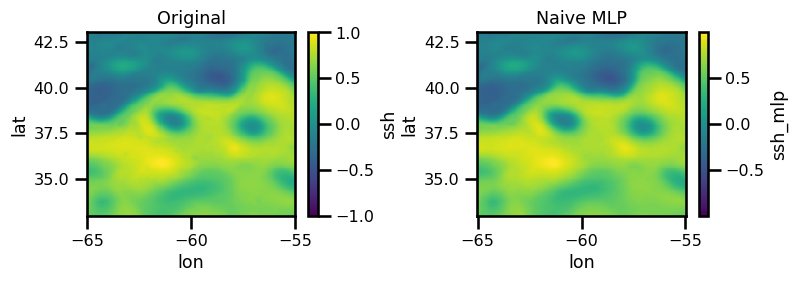

In [28]:
fig, ax = plt.subplots(ncols=2, figsize=(8,3))

xrda.ssh.isel(time=0).plot.pcolormesh(ax=ax[0], cmap="viridis")
ax[0].set(title="Original")

xrda.ssh_mlp.isel(time=0).plot.pcolormesh(ax=ax[1], cmap="viridis")
ax[1].set(title="Naive MLP")

plt.tight_layout()
plt.show()

### Random Fourier Features

$$
\boldsymbol{\phi}(\mathbf{x}) = 
\sqrt{\frac{\sigma^2}{N_{RF}}}
\left[
\cos(\boldsymbol{\Omega}\mathbf{x}),
\sin(\boldsymbol{\Omega}\mathbf{x})
\right]
$$

where $\boldsymbol{\Omega}$ is a random matrix sampled from a Gaussian distribution.

$$
\begin{aligned}
p(\Omega)&\sim\mathcal{N}(0,\boldsymbol{\Lambda}^{-1}_D) \\
\boldsymbol{\Lambda}_D &= \text{diag}
\left(\lambda_1, \lambda_2, \ldots, \lambda_D\right)
\end{aligned}
$$

So our final neural network with the additional basis function:

$$
\boldsymbol{f}(\mathbf{x};\boldsymbol{\theta}) =
\mathbf{w}^\top\boldsymbol{\phi}(\mathbf{x})+\mathbf{b}
$$

where $\boldsymbol{\phi}(\cdot)$ is the learned *basis network*.

In [29]:
from typing import Dict
from dataclasses import field

@dataclass
class RFFModel:
    _target_: str = "jejeqx._src.nets.nerfs.ffn.RFFNet"
    in_size: int = 2
    out_size: int = 1
    width_size: int = 256
    depth: int = 5
    ard: bool = True
    method: str = "rbf"
    key = jrandom.PRNGKey(123)

In [30]:
# initialize model
model_config = OmegaConf.structured(RFFModel())

model = hydra.utils.instantiate(model_config)

# check output of models
out = jax.vmap(model)(x_init)

assert out.shape == y_init.shape

In [31]:
seed = 123
debug = False
enable_progress_bar = False
log_dir = "./"

trainer = RegressorTrainer(
    model, 
    optimizer, 
    seed=seed, 
    debug=debug, 
    enable_progress_bar=enable_progress_bar,
    log_dir=log_dir
)

train_more = False

In [32]:
%%time


out, metrics = trainer.test_model(dm.test_dataloader())
metrics

CPU times: user 2.04 s, sys: 38 ms, total: 2.08 s
Wall time: 1.56 s


{'loss': 0.2993398606777191, 'psnr': 9.876240730285645}

In [33]:
try:
    trainer.load_model("./checkpoints/checkpoint_model_rff_ssh.ckpt")
except:
    pass

In [34]:
%%time


out, metrics = trainer.test_model(dm.test_dataloader())
metrics

CPU times: user 2.15 s, sys: 35.1 ms, total: 2.18 s
Wall time: 1.49 s


{'loss': 5.566898835240863e-06, 'psnr': 114.98343658447266}

In [35]:
try:
    trainer.load_model("./checkpoints/checkpoint_model_rff_ssh.ckpt")
except:
    pass

In [36]:
%%time

if train_more:

    metrics = trainer.train_model(dm, num_epochs=num_epochs)

CPU times: user 0 ns, sys: 26 µs, total: 26 µs
Wall time: 51.5 µs


In [37]:
out, metrics = trainer.test_model(dm.test_dataloader())

metrics

{'loss': 5.566898835240863e-06, 'psnr': 114.98343658447266}

In [38]:
if train_more:
    trainer.save_model("./checkpoints/checkpoint_model_rff_ssh.ckpt")

In [39]:
xrda["ssh_rfe"] = dm.data_to_df(out).to_xarray().ssh
xrda["ssh_rfe"].attrs["standard_name"] = "Sea Surface Height"

In [40]:
ssh_fn_rff = trainer.model

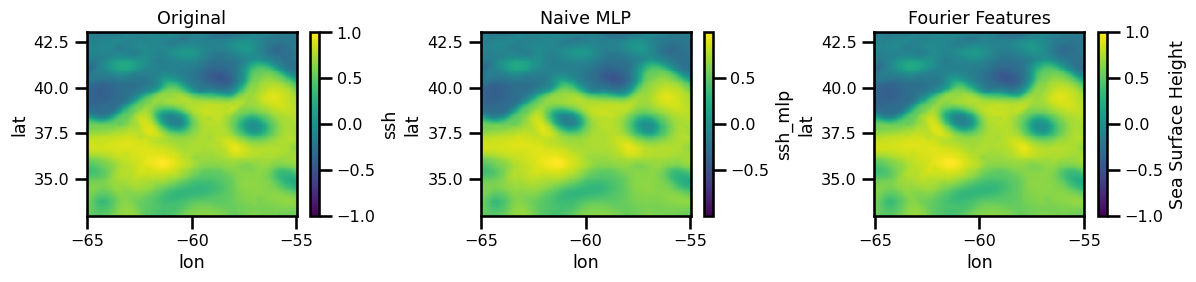

In [41]:
fig, ax = plt.subplots(ncols=3, figsize=(12,3))

xrda.ssh.isel(time=0).plot.pcolormesh(ax=ax[0], cmap="viridis")
ax[0].set(title="Original")

xrda.ssh_mlp.isel(time=0).plot.pcolormesh(ax=ax[1], cmap="viridis")
ax[1].set(title="Naive MLP")

xrda.ssh_rfe.isel(time=0).plot.pcolormesh(ax=ax[2], cmap="viridis")
ax[2].set(title="Fourier Features")


plt.tight_layout()
plt.show()

## Custom Activation Functions


**SIREN**

One of the most famous methods is the SIREN method. This replaces the standard activation function, $\sigma$, with a sinusoidal function.

$$
\phi(\mathbf{x})_\ell = \sin 
\left( \omega_\ell\left( 
\mathbf{w}_\ell\mathbf{x} + \mathbf{b}_\ell
\right)\right)
$$

In [42]:
model_name = "siren"

@dataclass
class Key:
    _target_: str = "jax.random.PRNGKey"
    seed: int = 123
    

@dataclass
class SirenBasis:
    _target_: str = "jejeqx._src.nets.nerfs.siren.SirenNet"
    in_size: int = 2
    out_size: int = 256
    width_size: int = 256
    depth: int = 4
    key: Key = Key()

So our final neural network with the additional basis function:

$$
\boldsymbol{f}(\mathbf{x};\boldsymbol{\theta}) =
\mathbf{w}^\top\boldsymbol{\phi}(\mathbf{x})+\mathbf{b}
$$

where $\boldsymbol{\phi}(\cdot)$ is the learned *basis network*.

In [43]:
@dataclass
class LinearModel:
    _target_: str = "equinox.nn.Linear"
    in_features: int = 256
    out_features: int = 1
    use_bias: bool = True
    key: Key = Key()
    
@dataclass
class NerFModel:
    _target_: str = "jejeqx._src.nets.nerfs.base.NerF"
    basis_net: SirenBasis = SirenBasis()
    network: LinearModel = LinearModel()

And now we initialize everything.

In [44]:
# initialize model configuration
model_config = OmegaConf.structured(NerFModel())

# initialize the model
model = hydra.utils.instantiate(model_config)

# check output of models
out = jax.vmap(model)(x_init)

# check the shape
assert out.shape == y_init.shape

In [45]:
seed = 123
debug = False
enable_progress_bar = False
log_dir = "./"

trainer = RegressorTrainer(
    model, 
    optimizer, 
    seed=seed, 
    debug=debug, 
    enable_progress_bar=enable_progress_bar,
    log_dir=log_dir
)

train_more = False

In [46]:
%%time


out, metrics = trainer.test_model(dm.test_dataloader())
metrics

CPU times: user 1.54 s, sys: 18.7 ms, total: 1.55 s
Wall time: 1.14 s


{'loss': 0.5013035535812378, 'psnr': 2.8449087142944336}

In [47]:

try:
    trainer.load_model("./checkpoints/checkpoint_model_siren_ssh.ckpt")
except:
    pass

In [48]:
%%time


out, metrics = trainer.test_model(dm.test_dataloader())
metrics

CPU times: user 186 ms, sys: 20.9 ms, total: 207 ms
Wall time: 180 ms


{'loss': 7.913218723842874e-06, 'psnr': 111.3497314453125}

In [49]:
# trainer.load_model("./checkpoints/checkpoint_model_siren_ssh.ckpt")

In [50]:
%%time

if train_more:

    metrics = trainer.train_model(dm, num_epochs=num_epochs)

CPU times: user 19 µs, sys: 6 µs, total: 25 µs
Wall time: 51.3 µs


In [51]:
out, metrics = trainer.test_model(dm.test_dataloader())

metrics

{'loss': 7.913218723842874e-06, 'psnr': 111.3497314453125}

In [52]:
if train_more:
    trainer.save_model("./checkpoints/checkpoint_model_siren_ssh.ckpt")

In [53]:
xrda["ssh_siren"] = dm.data_to_df(out).to_xarray().ssh
xrda["ssh_siren"].attrs["standard_name"] = "ssh"

In [54]:
ssh_fn_siren = trainer.model

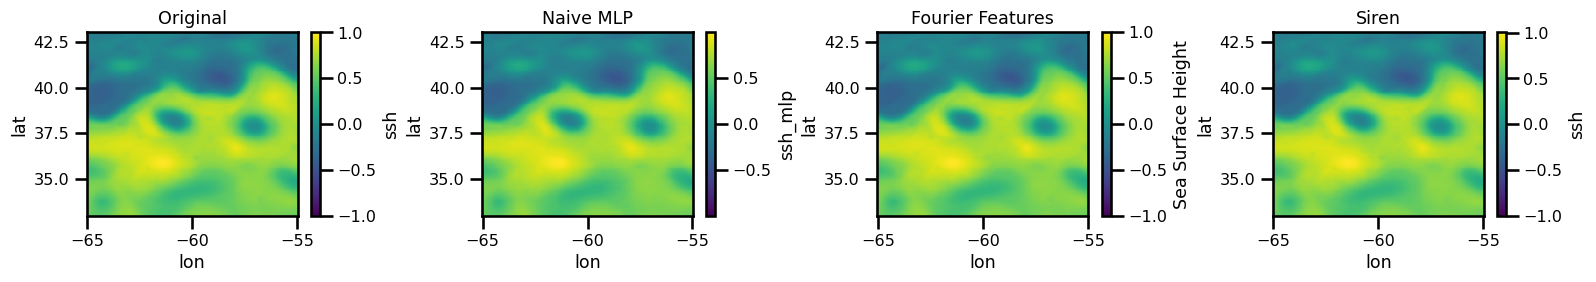

In [55]:
fig, ax = plt.subplots(ncols=4, figsize=(16,3))

xrda.ssh.isel(time=0).plot.pcolormesh(ax=ax[0], cmap="viridis")
ax[0].set(title="Original")

xrda.ssh_mlp.isel(time=0).plot.pcolormesh(ax=ax[1], cmap="viridis")
ax[1].set(title="Naive MLP")

xrda.ssh_rfe.isel(time=0).plot.pcolormesh(ax=ax[2], cmap="viridis")
ax[2].set(title="Fourier Features")

xrda.ssh_siren.isel(time=0).plot.pcolormesh(ax=ax[3], cmap="viridis")
ax[3].set(title="Siren")


plt.tight_layout()
plt.show()

## Derived Variables

In [56]:
# create function
ssh_fn: tp.Callable = ssh_fn_siren # ssh_fn_rff # ssh_fn_mlp #  

**Domain**

$$
\begin{aligned}
\text{Spatial}[m]: && 
\mathbf{x} &\in\Omega\in\mathbb{R}^{D}
\end{aligned}
$$

$$
\mathbf{x} = 
\begin{bmatrix}
\text{lat} \\ \text{lon}
\end{bmatrix}
$$







**Sea Surface Height**

The proper sea surface height equation is given by:

$$
\begin{aligned}
\text{Sea Surface Height}[m]: && 
\eta &=\boldsymbol{\eta}(\vec{\mathbf{x}},t) && && 
\boldsymbol{\eta}: \boldsymbol{\Omega}\times\boldsymbol{T}\rightarrow\mathbb{R}
\end{aligned}
$$

Here, we learned a parameterized function, $\boldsymbol{f_\theta}(\cdot)$, as a substitute for the true field. This is given by:

$$
\begin{aligned}
\boldsymbol{f} &=\boldsymbol{f}(\vec{\mathbf{x}},t;\boldsymbol{\theta})
&& && 
\boldsymbol{f}: \boldsymbol{\Omega}\times\boldsymbol{T}\times\boldsymbol{\Theta}\rightarrow\mathbb{R}
\end{aligned}
$$

In [57]:
# create FAST batched function
ssh_fn_batch: tp.Callable = jax.vmap(ssh_fn)

# make it FAST!
ssh_fn_batch: tp.Callable = jax.jit(ssh_fn_batch, backend="cpu")

# predict on the batch of coordinates
ssh: Array = ssh_fn_batch(dm.ds_test[:]["spatial"])

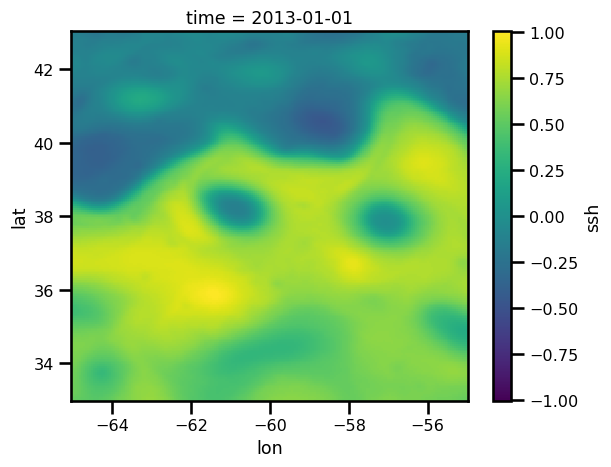

In [58]:
# create data array
xr_ssh: xr.Dataset = dm.data_to_df(ssh).to_xarray().ssh

# quick plot
xr_ssh.isel(time=0).plot.pcolormesh(cmap="viridis")

### Stream Function

$$
\begin{aligned}
\text{Stream Function }[ms^{-1}]: && 
\psi &=\boldsymbol{\psi}(\vec{\mathbf{x}},t) && && 
\boldsymbol{\psi}: \boldsymbol{\Omega}\times\boldsymbol{T}\rightarrow\mathbb{R}
\end{aligned}
$$


$$
\psi = \frac{g}{f_0}\eta
$$


In [59]:
from jejeqx._src.transforms.xarray.geostrophic import calculate_coriolis
from metpy.constants import earth_gravity

f0 = calculate_coriolis(xrda.lat)
print(f"Coriolis Parameter:", f0)
print(f"Earth Gravity:", earth_gravity)

Coriolis Parameter: <xarray.DataArray ()>
<Quantity(8.96744259e-05, '1 / second')>
Earth Gravity: 9.80665 meter / second ** 2


In [60]:
f0: Array = jnp.asarray(calculate_coriolis(xrda.lat).data.magnitude)
g: Array = jnp.asarray(earth_gravity.magnitude)

In [61]:

def create_streamfn(f: tp.Callable, f0: float=1e-5, g: float=9.81) -> tp.Callable:
    def sfn(x: Array) -> Array:
        return (g/f0) * f(x)
    return sfn

In [62]:
psi_fn = create_streamfn(ssh_fn)

# create FAST Batched Function
psi_fn_batch = jax.jit(jax.vmap(psi_fn), backend="cpu")

In [63]:
# make predictions
psi = psi_fn_batch(dm.ds_test[:]["spatial"])

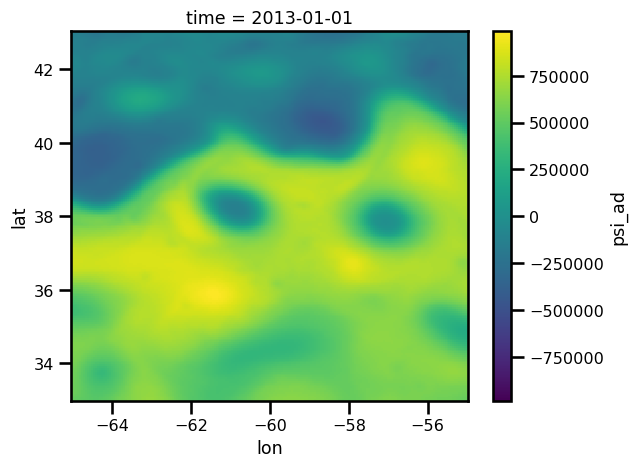

In [64]:
# create xarray dataset
xrda["psi"] = (g/f0) * xrda.ssh
xrda["psi_ad"] = dm.data_to_df(psi).to_xarray().ssh

# demo plot
xrda["psi_ad"].isel(time=0).plot.pcolormesh(cmap="viridis")

### Velocities

$$
\begin{aligned}
\text{U Velocity}[ms^{-1}]: && 
u &=\boldsymbol{u}(\vec{\mathbf{x}},t) && && 
\boldsymbol{\psi}: \boldsymbol{\Omega}\times\boldsymbol{T}\rightarrow\mathbb{R} \\
\text{V Velocity}[ms^{-1}]: && 
v &=\boldsymbol{v}(\vec{\mathbf{x}},t) && && 
\boldsymbol{\psi}: \boldsymbol{\Omega}\times\boldsymbol{T}\rightarrow\mathbb{R}
\end{aligned}
$$

$$
\begin{aligned}
u = -\frac{\partial \psi}{\partial y} && 
v = \frac{\partial \psi}{\partial x}
\end{aligned}
$$

In [65]:
def create_gradient_fn(f: tp.Callable) -> tp.Callable:
    def fn(x: Array) -> Array:
        return jax.jacfwd(f)(x).squeeze()
    return fn

def uv_velocity(grad_psi: Array) -> tp.Tuple[Array, Array]:
    dpsi_x, dpsi_y = jnp.split(grad_psi, 2, axis=-1)
    
    u = - dpsi_y
    v = dpsi_x
    return u, v
    

In [66]:
grad_psi_fn = create_gradient_fn(psi_fn)

grad_psi_fn_batched = jax.jit(jax.vmap(grad_psi_fn), backend="cpu")

In [67]:
# make predictions
grad_psi = grad_psi_fn_batched(dm.ds_test[:]["spatial"])


# parse to get velocity
u, v = uv_velocity(grad_psi)

In [68]:
# create xarray dataset
xrda["u"] = dm.data_to_df(u).to_xarray().ssh
xrda["v"] = dm.data_to_df(v).to_xarray().ssh

xrda["ke"] = np.hypot(xrda["u"], xrda["v"])

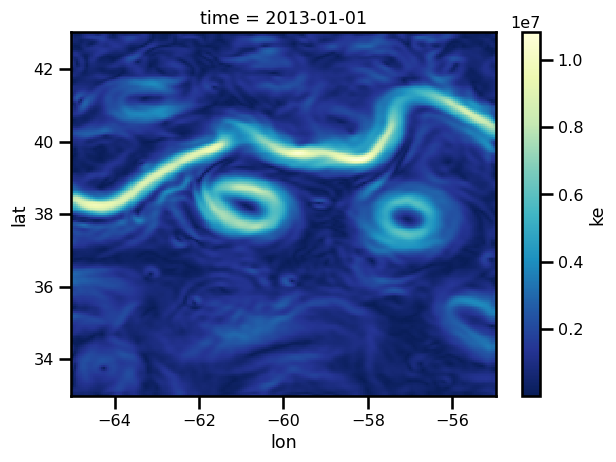

In [69]:
fig, ax = plt.subplots()

xrda["ke"].isel(time=0).plot.pcolormesh(ax=ax, cmap="YlGnBu_r")

plt.tight_layout()
plt.show()

#### Finite Difference 

So we can also do this in discrete space as well. Meaning, we can take the derivative of the field we are interested in.
$$
\frac{\partial \psi}{\partial x}= D[\psi](\vec{\mathbf{x}})
$$

We have many different types, e.g. central difference, forwards difference and backwards difference.

In [70]:
import finitediffx as fdx
import functools as ft

method = "central"
step_size = 1
accuracy = 1

@ft.partial(jax.jit, backend='cpu')
def dfdx(x: Array) -> Array:
    return fdx.difference(
        x, axis=1, accuracy=accuracy,
        method=method, step_size=step_size,
)

@ft.partial(jax.jit, backend='cpu')
def dfdy(x: Array) -> Array:
    return fdx.difference(
        x, axis=2, accuracy=accuracy,
        method=method, step_size=step_size,
)

In [71]:
# u velocity
u_fd = -dfdy(xrda["psi"].data)

# v velocity
v_fd = dfdx(xrda["psi"].data)

In [72]:
xrda["u_fd"] = (("time", "lat", "lon"), u_fd)
xrda["v_fd"] = (("time", "lat", "lon"), v_fd)

In [73]:

xrda["ke_fd"] = np.hypot(xrda["u_fd"], xrda["v_fd"])

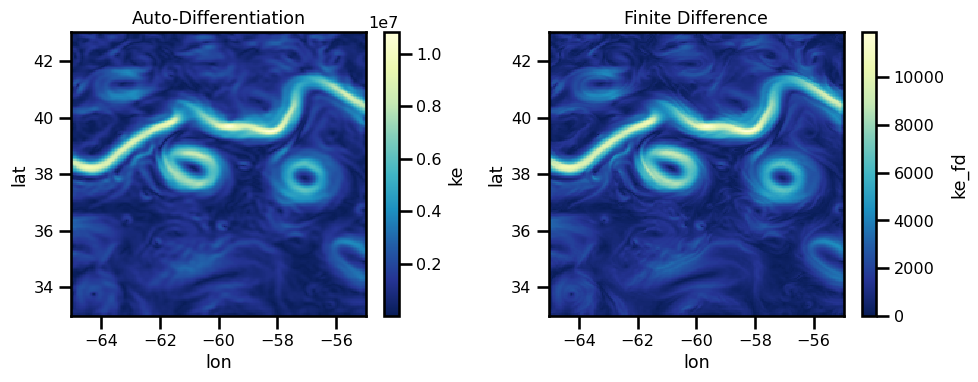

In [74]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))

xrda["ke"].isel(time=0).plot.pcolormesh(ax=ax[0], cmap="YlGnBu_r")
ax[0].set(title="Auto-Differentiation")
xrda["ke_fd"].isel(time=0).plot.pcolormesh(ax=ax[1], cmap="YlGnBu_r")
ax[1].set(title="Finite Difference")

plt.tight_layout()
plt.show()

## Relative Vorticity

Somtimes called the *vertical vorticity*.



$$
\zeta = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}
$$

Note that the u,v velocities can be calculated from the stream function as

$$
\begin{aligned}
u &= -\frac{\partial \psi}{\partial y} && &&
v = \frac{\partial \psi}{\partial x}\\
\end{aligned}
$$

So plugging these into the equation, we get:

$$
\begin{aligned}
\zeta &= 
\frac{\partial}{\partial x}\left(\frac{\partial \psi}{\partial x}\right) - 
\frac{\partial}{\partial y}\left( -\frac{\partial \psi}{\partial y}\right) \\
\zeta &= 
\frac{\partial^2 \psi}{\partial x^2}+ \frac{\partial^2 \psi}{\partial y^2}\\
\zeta &=\nabla^2\psi
\end{aligned}
$$

We can also calculate a normalized version

$$
\bar{\zeta} = \frac{\zeta}{f_0}
$$

Note: This is closely related to the geostrophic eqns:

$$
\begin{aligned}
\text{Relative Vorticity }[s^{-1}]: && 
\zeta &=\boldsymbol{\zeta}(\vec{\mathbf{x}},t) && && 
\boldsymbol{\xi}: \boldsymbol{\Omega}\times\boldsymbol{T}\rightarrow\mathbb{R}
\end{aligned}
$$

$$
\zeta = \nabla^2\psi
$$


In [75]:

def create_laplacian_fn(f: tp.Callable) -> tp.Callable:
    def fn(x: Array) -> Array:        
        # return jax.jacfwd(jax.jacrev(f))(x)
        H = jax.hessian(f)
        L = jnp.diagonal(H(x)[0])
        return jnp.sum(L, keepdims=True)
    return fn

In [76]:

rvort_fn = create_laplacian_fn(psi_fn)
rvort_fn(x_init[0])

rvort_fn_batched = jax.jit(jax.vmap(rvort_fn), backend="cpu")

In [77]:
rvort = rvort_fn_batched(dm.ds_test[:]["spatial"])

In [78]:
# create xarray dataset
xrda["rvort"] = dm.data_to_df(rvort).to_xarray().ssh

In [79]:
import finitediffx as fdx

method = "central"
order = 1
step_size = 1
accuracy = 1

dv_dx = dfdx(xrda["v_fd"].data)

du_dy = dfdy(xrda["u_fd"].data)

In [80]:

xrda["rvort_fd"] = (("time", "lat", "lon"), dv_dx - du_dy)

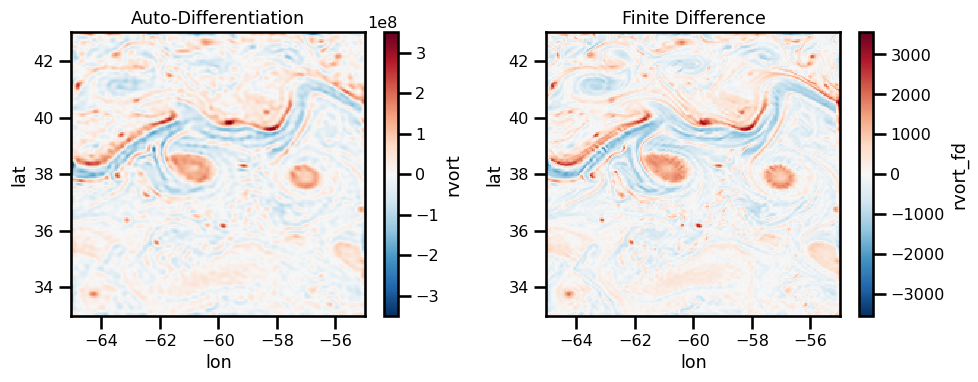

In [81]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))

xrda["rvort"].isel(time=0).plot.pcolormesh(ax=ax[0], cmap="RdBu_r")
ax[0].set(title="Auto-Differentiation")
xrda["rvort_fd"].isel(time=0).plot.pcolormesh(ax=ax[1], cmap="RdBu_r")
ax[1].set(title="Finite Difference")

plt.tight_layout()
plt.show()

In [126]:
import common_utils as cutils

In [127]:
ds_rfe = cutils.calculate_physical_quantities(xrda.ssh_rfe)
ds_natl60 = cutils.calculate_physical_quantities(xrda.ssh)
ds_mlp = cutils.calculate_physical_quantities(xrda.ssh_mlp)
ds_siren = cutils.calculate_physical_quantities(xrda.ssh_siren)

In [111]:
def rmse_da(da, da_ref, dim):
    return ((da - da_ref) ** 2).mean(dim=dim) ** 0.5


def nrmse_da(da, da_ref, dim):
    rmse = rmse_da(da=da, da_ref=da_ref, dim=dim)
    std = (da_ref**2).mean(dim=dim) ** 0.5    
    return 1.0 - (rmse / std).data.magnitude

In [112]:
import pandas as pd
dims = ["lat", "lon"]

results_df = pd.DataFrame()

for imodel, iname in zip(
    [ds_mlp, ds_rfe, ds_siren],
    ["MLP", "RFE", "SIREN"]
):
    for ivar in imodel:
        error = nrmse_da(imodel[ivar], ds_natl60[ivar], dims)
        
        ires_df = pd.DataFrame(
            data=[[iname, ivar, error.item()]],
            columns = [ "model", "variable", "nrmse",],
        )
        
        results_df = pd.concat([ires_df, results_df.loc[:]], axis=0)

In [113]:
results_df.head()

,model,variable,nrmse
0,SIREN,ow,0.385975
0,SIREN,strain,0.622677
0,SIREN,vort_r,0.535637
0,SIREN,ke,0.943542
0,SIREN,v,0.882298


In [114]:
results_df.loc[results_df['variable'] == "ke"].sort_values("nrmse")

,model,variable,nrmse
0,MLP,ke,0.877560
0,RFE,ke,0.940009
0,SIREN,ke,0.943542


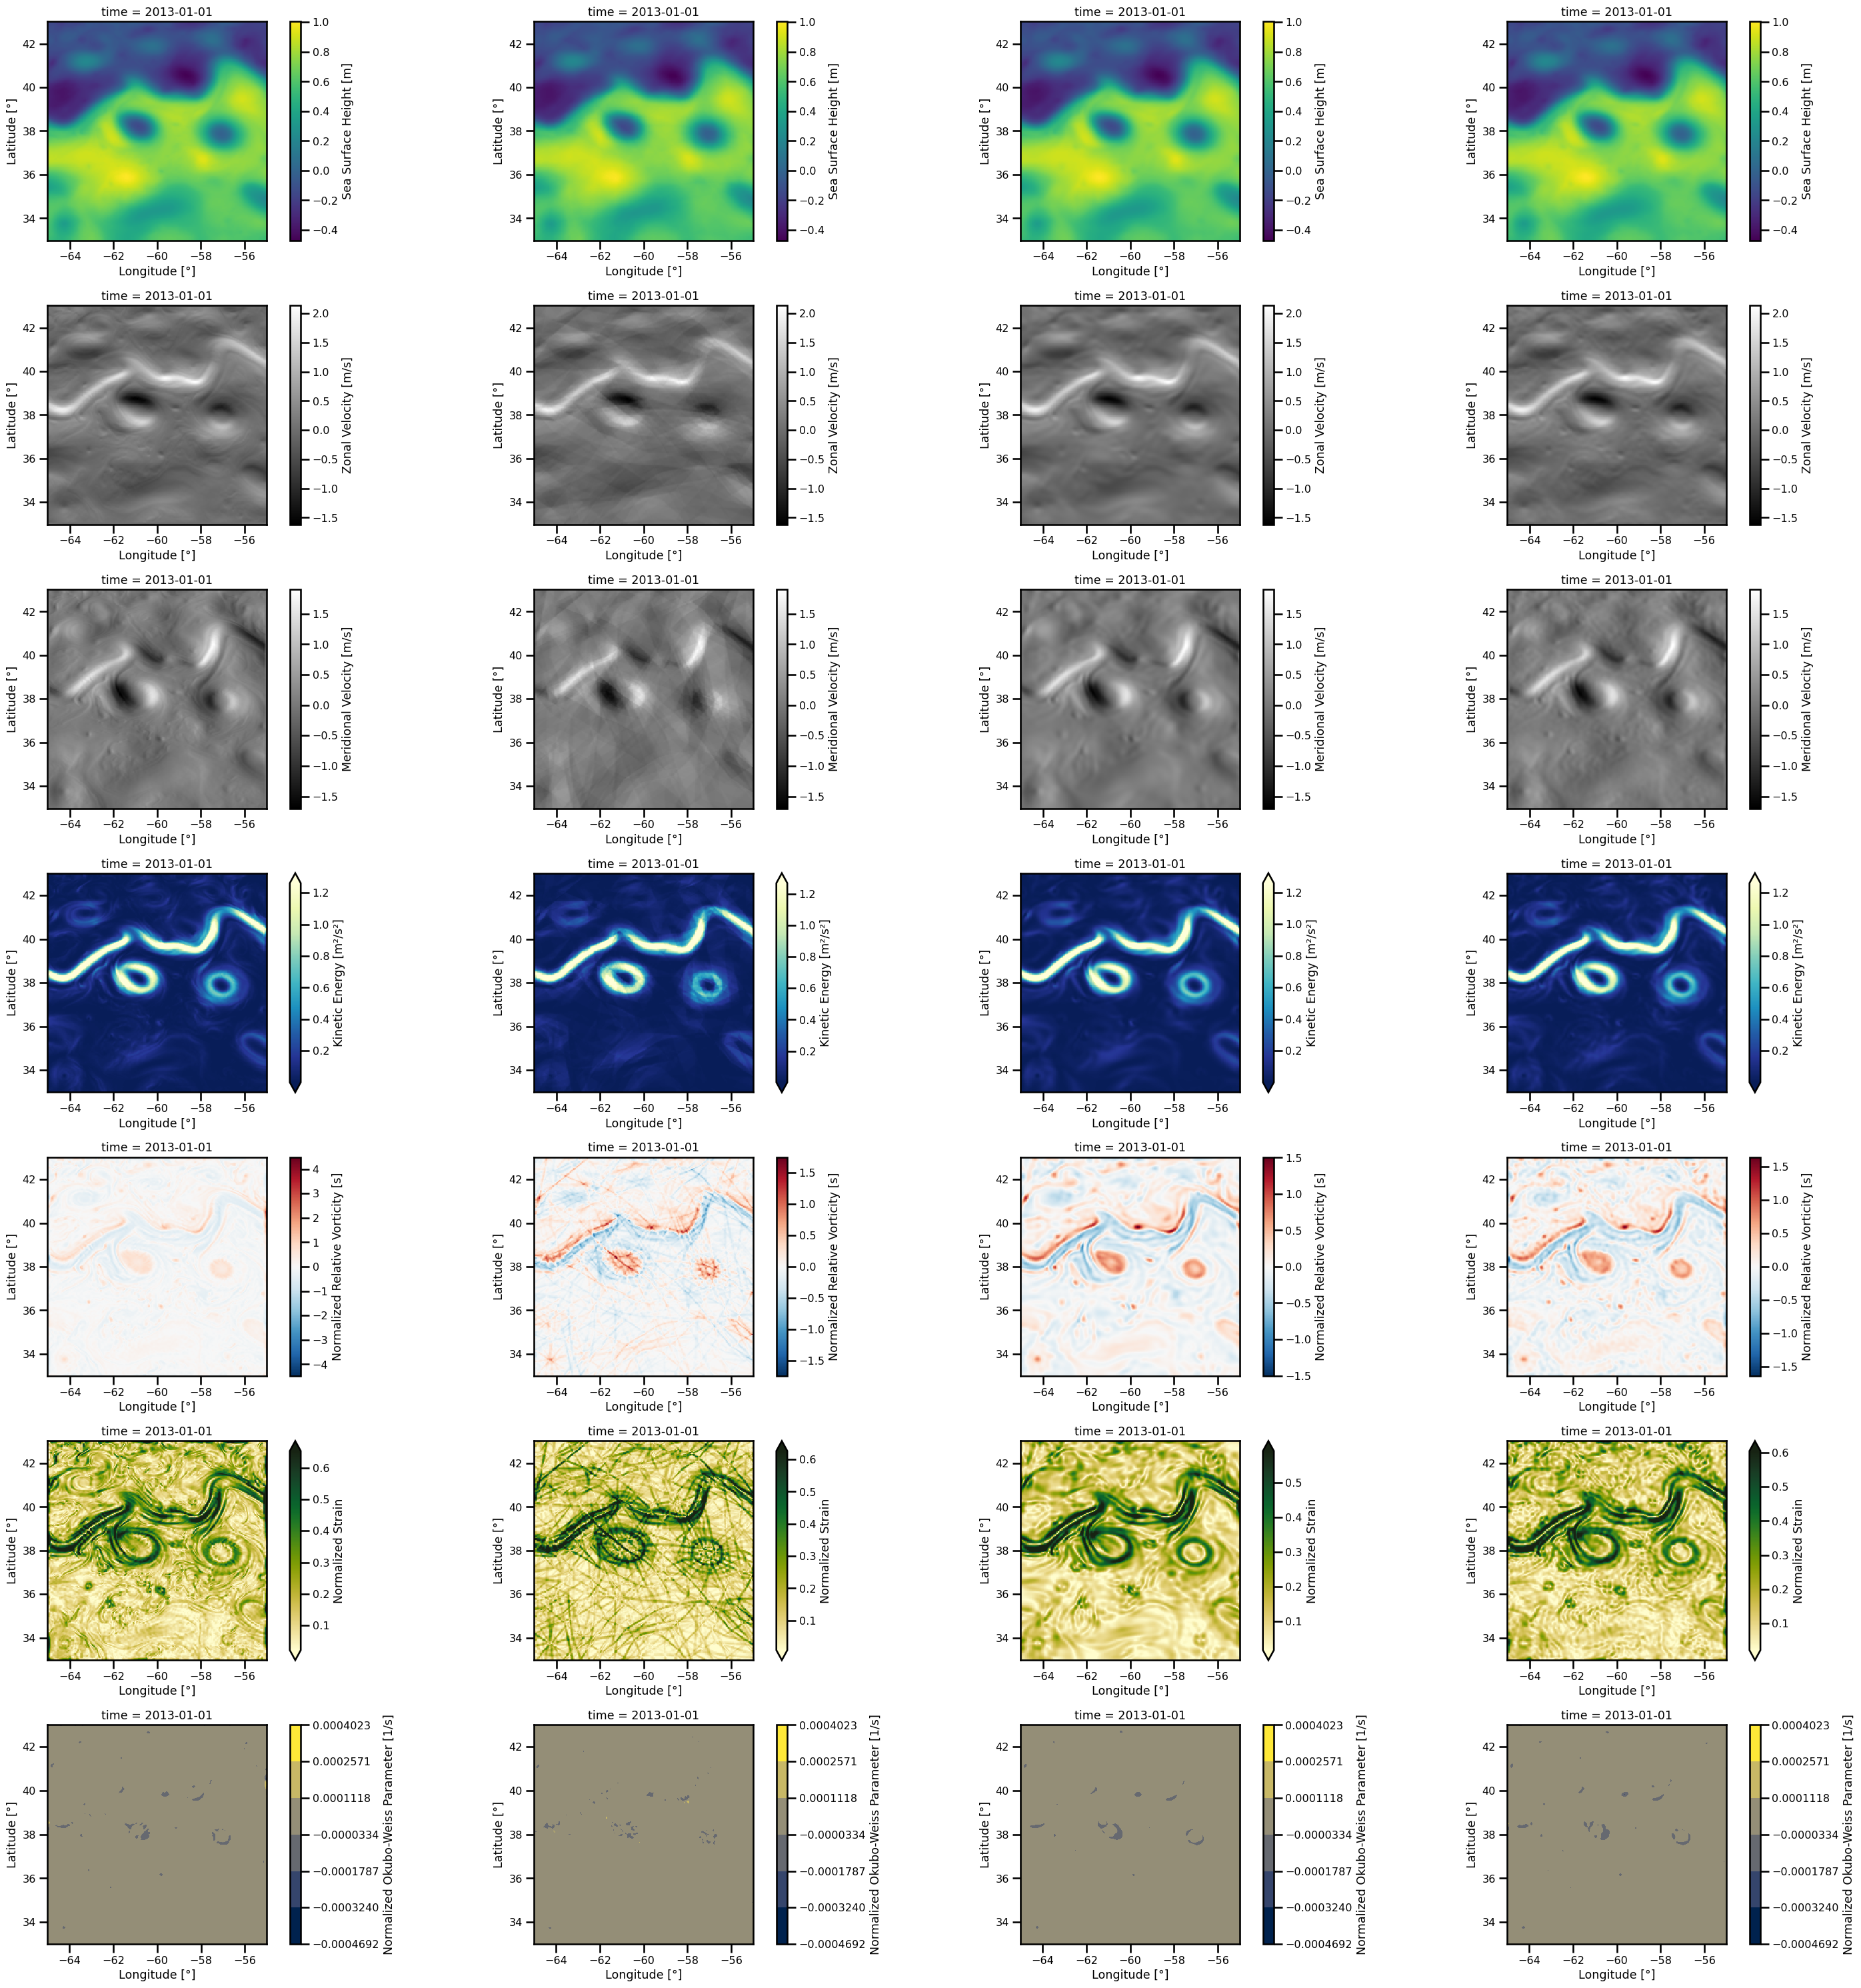

In [133]:
fig, ax = cutils.plot_analysis_vars([
    ds_natl60.isel(time=0),
    ds_mlp.isel(time=0),
    ds_rfe.isel(time=0),
    ds_siren.isel(time=0),
], figsize=(30,30)
)
# fig.suptitle("NATL60   |   MLP   |      RFE     |      SIREN"), 
plt.show()

In [ ]:
# 

In [116]:
ds_psd_natl60 = cutils.calculate_isotropic_psd(ds_natl60)
ds_psd_rfe = cutils.calculate_isotropic_psd(ds_rfe)
ds_psd_mlp = cutils.calculate_isotropic_psd(ds_mlp)
ds_psd_siren = cutils.calculate_isotropic_psd(ds_siren)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
fig, ax = cutils.plot_analysis_psd_iso(
    [ds_psd_natl60, ds_psd_mlp, ds_psd_rfe, ds_psd_siren],
    ["NATL60", "MLP", "RFE", "SIREN" ]
)
plt.show()

In [118]:
ds_rfe_scores = cutils.calculate_isotropic_psd_score(ds_rfe, ds_natl60)
ds_mlp_scores = cutils.calculate_isotropic_psd_score(ds_mlp, ds_natl60)
ds_siren_scores = cutils.calculate_isotropic_psd_score(ds_siren, ds_natl60)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [119]:
import pandas as pd
results_df = pd.DataFrame(columns=[
                    "model",
                    "variable",
                    "wavelength [km]",
                    "wavelength [degree]"
                ])

for iscore, imodel in zip(
    [ds_mlp_scores, ds_rfe_scores, ds_siren_scores],
    ["MLP", "RFE", "SIREN"]
):
    for ivar in iscore:
        resolved_spatial_scale = iscore[ivar].attrs["resolved_scale_space"] / 1e3 
        
        ires_df = pd.DataFrame(
            data=[[imodel, ivar, resolved_spatial_scale, resolved_spatial_scale/111]],
            columns = [ "model", "variable", "wavelength [km]", "wavelength [degree]" ],
        )
        
        results_df = pd.concat([ires_df, results_df.loc[:]], axis=0)

In [123]:
results_df.head()

,model,variable,wavelength [km],wavelength [degree]
0,SIREN,strain,19.781224,0.178209
0,SIREN,vort_r,22.769934,0.205135
0,SIREN,ke,21.237584,0.191330
0,SIREN,ssh,22.981503,0.207041
0,RFE,strain,22.680120,0.204325


In [121]:
results_df.loc[results_df['variable'] == "strain"].sort_values("wavelength [km]")

,model,variable,wavelength [km],wavelength [degree]
0,SIREN,strain,19.781224,0.178209
0,RFE,strain,22.680120,0.204325
0,MLP,strain,76.604625,0.690132


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

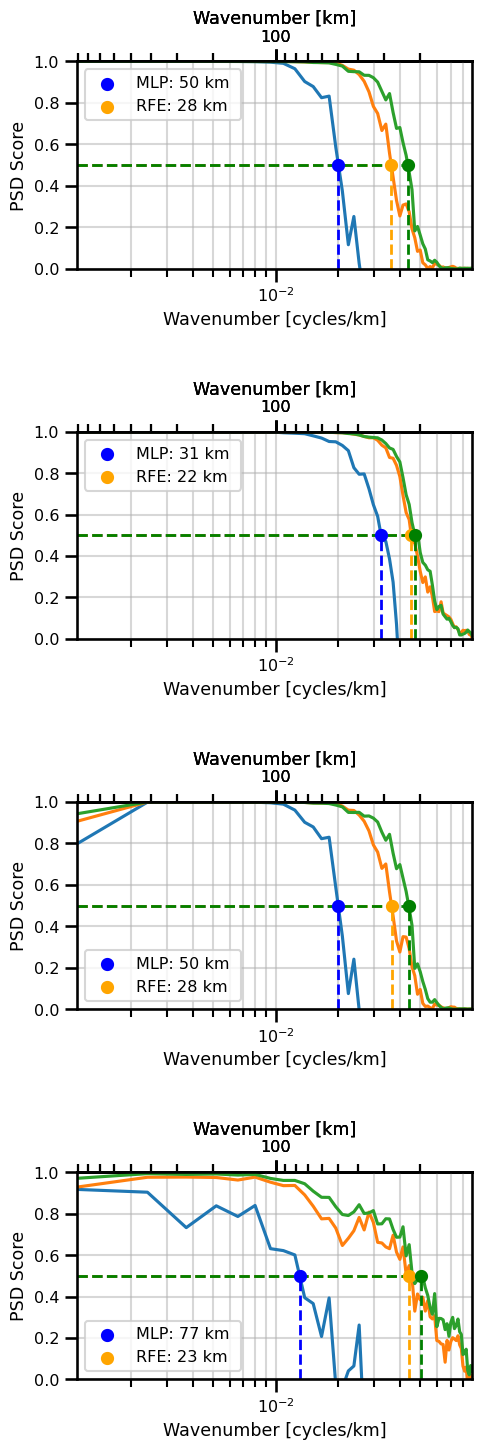

In [124]:
cutils.plot_analysis_psd_iso_score(
    [ds_mlp_scores, ds_rfe_scores, ds_siren_scores], 
    ["MLP", "RFE", "SIREN"], 
    ["b", "orange", "green"])
plt.show()